In [1]:
import pandas as pd
# import geopandas
import numpy as np
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import dill
import re
import time

In [81]:
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import Ridge
from sklearn.metrics import accuracy_score, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor, LocalOutlierFactor
from sklearn.pipeline import Pipeline, FeatureUnion,TransformerMixin
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, MaxAbsScaler, minmax_scale, StandardScaler, OrdinalEncoder 
from sklearn.preprocessing import RobustScaler, Normalizer, QuantileTransformer, PowerTransformer
from sklearn.utils import shuffle
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

In [ ]:
df_station = dill.load(open(folder+'df_station.pkd', 'rb'))

In [ ]:
df_station.reset_index(inplace=True)

In [ ]:
df_station.drop(index=0,inplace=True)

In [ ]:
df_station.reset_index(drop=True,inplace=True)

In [ ]:
df_station_nan = df_station.loc[df_station.isnull().Entries_change]

In [ ]:
# i =300
# df_station_nan.iloc[i:i+60]

In [ ]:
df_station_del_na = df_station.loc[~ df_station.isnull().Entries_change]

In [ ]:
df_station_del_na.drop(columns=['Entries_change_hourly','Exits_change_hourly'], inplace=True)

In [ ]:
def interval_code(row):
    datepattern = '[0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]'
    if re.findall(pattern=datepattern+', ', string=str(row['Timegrp'])):
        return 0
    elif re.findall(pattern=datepattern+' 04:00:00, ', string=str(row['Timegrp'])):
        return 1
    elif re.findall(pattern=datepattern+' 08:00:00, ', string=str(row['Timegrp'])):
        return 2
    elif re.findall(pattern=datepattern+' 12:00:00, ', string=str(row['Timegrp'])):
        return 3
    elif re.findall(pattern=datepattern+' 16:00:00, ', string=str(row['Timegrp'])):
        return 4
    elif re.findall(pattern=datepattern+' 20:00:00, ', string=str(row['Timegrp'])):
        return 5
    return None

In [ ]:
df_station_del_na['interval_code'] = df_station_del_na.apply(lambda row: interval_code(row), axis=1)

In [ ]:
def weekday_code(row):
    d = re.findall(pattern='(?<=\()[0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]', 
                   string=str(row['Timegrp']))
    return pd.Timestamp(d[0]).weekday()

In [ ]:
df_station_del_na['weekday_code'] = df_station_del_na.apply(lambda row: weekday_code(row), axis=1)

In [ ]:
df_station_del_na.head(7)

In [ ]:
dill.dump(df_station_del_na, open(folder+'df_station_del_na.pkd', 'wb'))

In [4]:
df_station_del_na = dill.load(open('df_station_del_na.pkd', 'rb'))

In [6]:
df_station_del_na.reset_index(drop=True,inplace=True)

In [ ]:
class OutlierExtractor(TransformerMixin):
    def __init__(self, columns, **kwargs):
        """
        Keyword Args:
            neg_conf_val (float): The threshold for excluding samples with a lower
               negative outlier factor.

        Returns:
            object: to be used as a transformer method as part of Pipeline()
        """
        self.threshold = kwargs.pop('neg_conf_val', -10.0)
        self.columns = columns
        self.kwargs = kwargs
    
    def fit(self, *args, **kwargs):
        return self

    def transform(self, X, y=None):
        """
        Returns:
            ndarray: subsampled data
        Notes:
            X should be of shape (n_samples, n_features)
        """
        X_ = np.asarray(X[self.columns])
        y = np.asarray(y)
        lcf = LocalOutlierFactor(**self.kwargs)
        lcf.fit(X_)
        return (X[lcf.negative_outlier_factor_ > self.threshold, :],
                y[lcf.negative_outlier_factor_ > self.threshold])



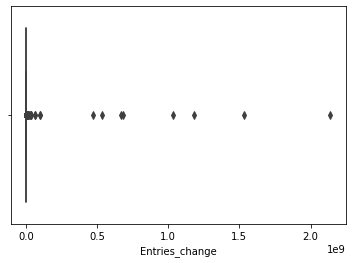

In [80]:
sns.boxplot(x=df_station_del_na['Entries_change'])

In [50]:
q1 = df_station_del_na[['Entries_change', 'Exits_change']].quantile(0.25)
q3 = df_station_del_na[['Entries_change', 'Exits_change']].quantile(0.75)
IQR = q3- q1
df2 = df_station_del_na[ 
                        (df_station_del_na['Entries_change'] < (q3['Entries_change'] + 1.5 * IQR['Entries_change'])) &
                        (df_station_del_na['Exits_change'] < (q3['Exits_change'] + 1.5 * IQR['Exits_change']))]
df2.reset_index(drop=True,inplace=True)

In [51]:
df2.describe()

,Entries_change,Exits_change,interval_code,weekday_code
count,334922.000000,334922.000000,334922.000000,334922.000000
mean,392.086268,408.704621,2.413655,3.051902
std,391.988139,405.667757,1.738674,2.024624
min,0.000000,0.000000,0.000000,0.000000
25%,83.000000,98.000000,1.000000,1.000000
50%,263.000000,270.000000,2.000000,3.000000
75%,580.000000,592.000000,4.000000,5.000000
max,1815.000000,1868.000000,5.000000,6.000000


<AxesSubplot:xlabel='Entries_change'>

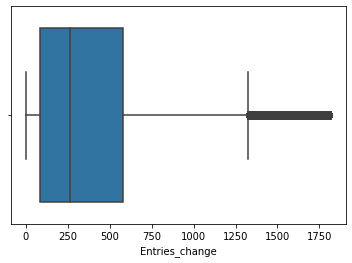

In [52]:
sns.boxplot(x=df2['Entries_change'])

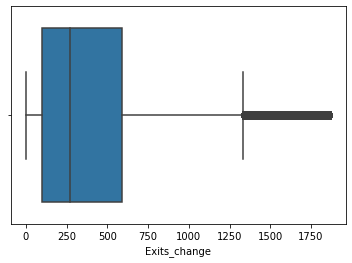

In [106]:
sns.boxplot(x=df2['Exits_change'])

In [10]:
X = df2[['Station', 'interval_code', 'weekday_code']]
y = df2['Exits_change']

In [55]:
outlierextract_columns1 = ['Entries_change']
outlierextract_columns2 = ['Exits_change']
# df1 = OutlierExtractor(outlierextract_columns1).fit_transform(df_station_del_na)

In [56]:
X_ = np.asarray(df_station_del_na[outlierextract_columns1])
lcf = LocalOutlierFactor()
lcf.fit(X_)

LocalOutlierFactor(algorithm='auto', contamination='auto', leaf_size=30,
                   metric='minkowski', metric_params=None, n_jobs=None,
                   n_neighbors=20, novelty=False, p=2)

In [57]:
lcf.negative_outlier_factor_.shape

(380741,)

In [23]:
df_station_del_na.shape

(380741, 6)

In [78]:
df1 = df_station_del_na[lcf.negative_outlier_factor_ > -2.5]
df1.shape

(378546, 6)

In [ ]:
df1.describe()

In [ ]:
z = np.abs(stats.zscore(df_station_del_na[['Entries_change','Exits_change']]))

In [ ]:
np.where(z>3)[0].shape

(5686,)

In [ ]:
drop_index = np.unique(np.where(z>3)[0])

In [ ]:
df_station_del_na.drop(labels=drop_index, axis=0, inplace=True)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
X_train.shape

(267937, 3)

In [13]:
categorical_columns = ['Station', 'interval_code', 'weekday_code']
numeric_columns = ['Entries_change']
y_colums = ['Exits_change']

In [14]:
features = ColumnTransformer([
    ('categorical', OneHotEncoder(), categorical_columns),
    # ('numeric', MaxAbsScaler(), numeric_columns)
])

est = Pipeline([
    ('features', features),
    # ('scaler', RobustScaler(with_centering=False)),
    # ('regressor', RandomForestRegressor())
    ('regressor', Ridge())
])

In [19]:
est.fit(X_train,  y_train);

In [ ]:
est.get_params()

In [16]:
est.score(X_train,  y_train)

0.6005702267743751

In [104]:
X_train.iloc[0]

Station          42 ST-BRYANT PK
interval_code                  2
weekday_code                   5
Name: 68088, dtype: object

In [20]:
y_train_pred = est.predict(X_train)
r2_score(y_true=y_train, y_pred=y_train_pred)

0.6005702267743751

In [17]:
est.score(X_test, y_test)

0.598897223916298

In [ ]:
y_test_pred = est.predict(X_test)
r2_score(y_true=y_test, y_pred=y_test_pred)

-1.2213005772223284

In [18]:
with open('est_onehot_ridge.dill', 'wb') as f:
    dill.dump(est, f)

In [92]:
station_embed = OneHotEncoder()
station_trans = station_embed.fit_transform(pd.DataFrame(df2['Station'].str.lower()))

In [54]:
station_trans.toarray().shape

(334922, 379)

In [55]:
station_back = station_embed.inverse_transform(station_trans)

In [93]:
test_station_onehot = np.zeros((1,379))
test_station_onehot[0][12] = 1
station_embed.inverse_transform(test_station_onehot)

array([['138/grand conc']], dtype=object)

In [94]:
with open('station_embed.dill', 'wb') as f:
    dill.dump(station_embed, f)

In [112]:
station_name = df2['Station'].unique()

In [113]:
with open('station_name.dill', 'wb') as f:
    dill.dump(station_name, f)

In [98]:
datearray = np.zeros((1, 7))
datearray[0][0] = 1
intervalarray = np.zeros((1, 6))
intervalarray[0][0] = 1
station_count = 379
stationarray = np.zeros((1, station_count))
stationarray[0][0] = 1
newarray = np.concatenate((datearray,intervalarray,stationarray), axis=1)
newarray.shape

(1, 392)

In [114]:
station_name

array(['1 AV', '103 ST', '103 ST-CORONA', '104 ST', '110 ST', '111 ST',
       '116 ST', '116 ST-COLUMBIA', '121 ST', '125 ST', '135 ST',
       '137 ST CITY COL', '138/GRAND CONC', '14 ST', '14 ST-UNION SQ',
       '145 ST', '149/GRAND CONC', '14TH STREET', '15 ST-PROSPECT',
       '155 ST', '157 ST', '161/YANKEE STAD', '163 ST-AMSTERDM', '167 ST',
       '168 ST', '169 ST', '170 ST', '174 ST', '174-175 STS', '175 ST',
       '176 ST', '18 AV', '18 ST', '181 ST', '182-183 STS', '183 ST',
       '190 ST', '191 ST', '2 AV', '20 AV', '207 ST', '21 ST',
       '21 ST-QNSBRIDGE', '215 ST', '219 ST', '225 ST', '23 ST', '231 ST',
       '233 ST', '238 ST', '25 AV', '25 ST', '28 ST', '3 AV',
       '3 AV 138 ST', '3 AV-149 ST', '30 AV', '33 ST', '33 ST-RAWSON ST',
       '34 ST-HERALD SQ', '34 ST-HUDSON YD', '34 ST-PENN STA', '36 AV',
       '36 ST', '39 AV', '4 AV-9 ST', '40 ST LOWERY ST',
       '42 ST-BRYANT PK', '42 ST-PORT AUTH', '45 ST', '46 ST',
       '46 ST BLISS ST', '47-50 STS ROCK

In [128]:
testarray = pd.DataFrame([[station_name[0],5,2]], columns=X_train.columns)

In [132]:
X_train.columns

Index(['Station', 'interval_code', 'weekday_code'], dtype='object')

In [158]:
est.named_steps['features'].get_feature_names.__subclasshook__

<function method.__subclasshook__>